## Web Mining - TP Stocks - Grupo 4

### Librerias

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
import spacy # Python 3.12
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Archivo entrenamiento

In [8]:
data = pd.read_excel('C:/Austral/mcd-text-mining/TP Final/Source/ypf_v6.xlsx', sheet_name= 'UNIFICADO')

## Preprocesamiento

### Stopwords

In [15]:
stopwords_en = set(stopwords.words('english'))

In [16]:
# Listado de stopwords propio
stopwords_personales = ['Refinitiv','Zacks','Rystad','Andrew','Rocco','Nilanjan','Benerjee','CERAWEEK','Tirthankar','Chakraborty','Anindya','Barman','Scott','Squires','Jonathan','Gilbert','Yvonne','Yue','Li'
                        'Laura','Millan','Jorgelina','Do','Rosario']

stopwords_personales = [x.lower() for x in stopwords_personales]

stopwords_custom = stopwords_en.union(stopwords_personales)

### Bag Of Words

In [7]:
word_count = {}

for sentence in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    words = sentence.split()
    
    for word in words:
        word = word.strip(".,!?()").lower()
        
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

In [8]:
word_count_filtro = {word: count for word, count in word_count.items() if word not in stopwords_en}

In [9]:
word_counts_orden = dict(sorted(word_count_filtro.items(), key=lambda x: x[1], reverse=True))

In [10]:
df = pd.DataFrame(list(word_counts_orden.items()), columns=['Palabra', 'Frecuencia'])
file_path = 'bag_of_words.xlsx'
df.to_excel(file_path, index=False)

### Power Words

In [11]:
column1_values = data['Power Word 01'].tolist()
column2_values = data['Power Word 02'].tolist()
column3_values = data['Power Word 03'].tolist()
column4_values = data['Power Word 04'].tolist()
column5_values = data['Power Word 05'].tolist()
column6_values = data['Power Word 06'].tolist()
column7_values = data['Power Word 07'].tolist()
column8_values = data['Power Word 08'].tolist()

In [12]:
combined_values = set(
    column1_values + 
    column2_values + 
    column3_values + 
    column4_values + 
    column5_values + 
    column6_values + 
    column7_values + 
    column8_values
    )

In [13]:
unique_values_list = list(combined_values)
unique_values_list = [value for value in unique_values_list if pd.notna(value)]
powerWords = [str(value).lower() for value in unique_values_list]

### Función de Lematización

In [28]:
import en_core_web_sm

In [31]:
def func_lemma(X_train, dicc_stopwords):
    
    nlp = spacy.load("en_core_web_sm")
    #pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
    
    X_train_lemma = []

    for noticia in X_train:
        l_doc = nlp(noticia)
        v_lema = " ".join([token.lemma_.lower() for token in l_doc if token.text.lower() not in dicc_stopwords and not token.is_punct])
        X_train_lemma.append(v_lema)

    return X_train_lemma

### Split Train / Test

In [9]:
data_train = data[data['Train/Test'].isin(['Train'])]
data_test = data[data['Train/Test'].isin(['Test'])]

In [10]:
X_train = data_train['Text'].tolist()
y_train = data_train['Category'].tolist()

In [11]:
X_test = data_test['Text'].tolist()
y_test = data_test['Category'].tolist()

### Lemma (Similitud del Coseno y Jaccard)

Queremos verificar si aplicar lematización realmente cambia la composición del texto y si el texto transformado se reduce.

In [30]:
list1 = X_train
list2 = func_lemma(X_train, stopwords_custom)
vectorizer = CountVectorizer()

data_lemma = []

for str1, str2 in zip(list1, list2):
    tokens1 = str1.split()
    tokens2 = str2.split()

    matrix1 = vectorizer.fit_transform([" ".join(tokens1)])
    matrix2 = vectorizer.transform([" ".join(tokens2)])
    
    cosine_sim = cosine_similarity(matrix1, matrix2)[0][0]

    data_lemma.append([str1, str2, cosine_sim])

df_lemma = pd.DataFrame(data_lemma, columns=["Original", "Lemma", "Sim_Coseno"])

OSError: [E053] Could not read config file from c:\Users\ferna\AppData\Local\Programs\Python\Python312\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.0\config.cfg

In [13]:
df_lemma.head()

NameError: name 'df_lemma' is not defined

In [18]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords_custom]
    return filtered_tokens

original_text = " ".join(list1)
lemmatized_text = " ".join(list2)

original_tokens = original_text.split()
lemmatized_tokens = lemmatized_text.split()

filtered_original_tokens = remove_stopwords(original_tokens)
filtered_lemmatized_tokens = remove_stopwords(lemmatized_tokens)

original_unique_words = set(filtered_original_tokens)
lemmatized_unique_words = set(filtered_lemmatized_tokens)

total_unique_words_original = len(original_unique_words)
total_unique_words_lemmatized = len(lemmatized_unique_words)

print(f"Diccionario original: {total_unique_words_original}")
print(f"Diccionario lematizado: {total_unique_words_lemmatized}")

Diccionario original: 1710
Diccionario lematizado: 1252


Vemos que el diccionario de términos luego de la lematización no se reduce significativamente.

## Entrenamiento

### Regresión Logistica

#### Pipeline

In [19]:
clf_lr = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

clf_lr_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

#### Entrenamiento

In [20]:
clf_lr = clf_lr.fit(X_train, y_train)

clf_lr_sw = clf_lr_sw.fit(X_train, y_train)

clf_lr_lema = clf_lr.fit(func_lemma(X_train,stopwords_custom), y_train)

#### Predicción ( Etiquetas )

In [21]:
y_pred_lr = clf_lr.predict(X_test)

y_pred_lr_sw = clf_lr_sw.predict(X_test)

y_pred_lr_lema = clf_lr_lema.predict(X_test)

#### Predicción ( Probabilidad )

In [22]:
y_pred_lr_proba = clf_lr.predict_proba(X_test)

y_pred_lr_sw_proba = clf_lr_sw.predict_proba(X_test)

y_pred_lr_lema_proba = clf_lr_lema.predict_proba(X_test)

#### Evaluación

In [23]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lr_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_lr_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_sw))

Accuracy: 69.05%

F1 Score: 68.99

Confusion Matrix:
 [[32 12]
 [14 26]]


### Naive Bayes Multinomial

#### Pipeline

In [24]:
clf_nb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

clf_nb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

#### Entrenamiento

In [25]:
clf_nb = clf_nb.fit(X_train, y_train)

clf_nb_sw = clf_nb_sw.fit(X_train, y_train)

clf_nb_lema = clf_nb.fit(func_lemma(X_train,stopwords_custom), y_train)

#### Predicción ( Etiquetas )

In [26]:
y_pred_nb = clf_nb.predict(X_test)

y_pred_nb_sw = clf_nb_sw.predict(X_test)

y_pred_nb_lema = clf_nb_lema.predict(X_test)

#### Predicción ( Probabilidad )

In [27]:
y_pred_nb_proba = clf_nb.predict_proba(X_test)

y_pred_nb_sw_proba = clf_nb_sw.predict_proba(X_test)

y_pred_nb_lema_proba = clf_nb_lema.predict_proba(X_test)

#### Evaluación

In [28]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


In [29]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_sw))

Accuracy: 66.67%

F1 Score: 64.66

Confusion Matrix:
 [[39  5]
 [23 17]]


In [30]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_lema))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


### Support Vector Classifier

#### Pipeline

In [32]:
clf_svc = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_proba = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

clf_svc_sw_proba = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

#### Entrenamiento

In [33]:
clf_svc = clf_svc.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw.fit(X_train, y_train)

clf_svc_lema = clf_svc.fit(func_lemma(X_train,stopwords_custom), y_train)

#### Predicción ( Etiquetas )

In [34]:
y_pred_svc = clf_svc.predict(X_test)

y_pred_svc_sw = clf_svc_sw.predict(X_test)

y_pred_svc_lema = clf_svc_lema.predict(X_test)

#### Predicción ( Probabilidad )

In [35]:
clf_svc = clf_svc_proba.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw_proba.fit(X_train, y_train)

clf_svc_lema = clf_svc_proba.fit(func_lemma(X_train,stopwords_custom), y_train)

In [36]:
y_pred_svc_proba = clf_svc.predict_proba(X_test)

y_pred_svc_sw_proba = clf_svc_sw.predict_proba(X_test)

y_pred_svc_lema_proba = clf_svc_lema.predict_proba(X_test)

#### Evaluación

In [37]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


In [38]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_sw))

Accuracy: 69.05%

F1 Score: 68.91

Confusion Matrix:
 [[33 11]
 [15 25]]


In [39]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_lema))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


### Random Forest

#### Pipeline

In [40]:
clf_rf = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

clf_rf_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

#### Entrenamiento

In [41]:
clf_rf = clf_rf.fit(X_train, y_train)

clf_rf_sw = clf_rf_sw.fit(X_train, y_train)

#### Predicción (Etiquetas)

In [42]:
y_pred_rf = clf_rf.predict(X_test)

y_pred_rf_sw = clf_rf_sw.predict(X_test)

#### Predicción (Probabilidad)

In [43]:
y_pred_rf_proba = clf_rf.predict_proba(X_test)

y_pred_rf_sw_proba = clf_rf_sw.predict_proba(X_test)

In [44]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 66.67%

F1 Score: 66.67

Confusion Matrix:
 [[28 16]
 [12 28]]


### XGBoost

#### Mapeo etiquetas

In [45]:
y_train_gb = data_train["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()
y_test_gb = data_test["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()

In [46]:
def map_value(value):
    if value == 0:
        return "Compra"
    else:
        return "Neutro"

#### Pipeline

In [47]:
clf_xgb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

clf_xgb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

#### Entrenamiento

In [48]:
clf_xgb = clf_xgb.fit(X_train, y_train_gb)

clf_xgb_sw = clf_xgb_sw.fit(X_train, y_train_gb)

#### Predicción (Etiquetas)

In [49]:
y_pred_xgb = clf_xgb.predict(X_test)

y_pred_xgb_sw = clf_xgb_sw.predict(X_test)

#### Predicción (Probabilidad)

In [50]:
y_pred_xgb_proba = clf_xgb.predict_proba(X_test)

y_pred_xgb_sw_proba = clf_xgb_sw.predict_proba(X_test)

#### Evaluación

In [51]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_xgb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_xgb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_xgb_sw))

Accuracy: 67.86%

F1 Score: 67.83

Confusion Matrix:
 [[31 13]
 [14 26]]


#### Remapeo de etiquetas

In [52]:
y_pred_xgb = [map_value(value) for value in y_pred_xgb]
y_pred_xgb_sw = [map_value(value) for value in y_pred_xgb_sw]

### LightGBM

#### Pipeline

In [53]:
clf_lgbm = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

clf_lgbm_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

#### Entrenamiento

In [54]:
clf_lgbm = clf_lgbm.fit(X_train, y_train_gb)

clf_lgbm_sw = clf_lgbm_sw.fit(X_train, y_train_gb)

[LightGBM] [Info] Number of positive: 104, number of negative: 119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466368 -> initscore=-0.134733
[LightGBM] [Info] Start training from score -0.134733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

#### Predicción (Etiquetas)

In [56]:
y_pred_lgbm = clf_lgbm.predict(X_test)

y_pred_lgbm_sw = clf_lgbm_sw.predict(X_test)

#### Predicción (Probabilidad)

In [55]:
y_pred_lgbm_proba = clf_lgbm.predict_proba(X_test)

y_pred_lgbm_sw_proba = clf_lgbm_sw.predict_proba(X_test)

#### Evaluación

In [57]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_lgbm_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_lgbm_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_lgbm_sw))

Accuracy: 66.67%

F1 Score: 66.61

Confusion Matrix:
 [[31 13]
 [15 25]]


#### Remapeo de etiquetas

In [58]:
y_pred_lgbm = [map_value(value) for value in y_pred_lgbm]
y_pred_lgbm_sw = [map_value(value) for value in y_pred_lgbm_sw]

### Word2Vec

Utilizamos el modelo de GoogleNews disponible en: https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [55]:
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('C:/Austral/GoogleNews-vectors-negative300.bin.gz', binary = True,)

In [56]:
corpus = data['Text'].values

vectorizer = CountVectorizer(stop_words = stopwords_custom)

X = vectorizer.fit_transform(corpus)

CountVectorizedData = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
CountVectorizedData['Category'] = data['Category']
CountVectorizedData['Split'] = data['Train/Test']

WordsVocab = CountVectorizedData.columns[:-2]

In [57]:
def FunctionText2Vec(inpTextData):
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    W2Vec_Data=pd.DataFrame()
    
    for i in range(CountVecData.shape[0]):

        Sentence = np.zeros(300)

        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            if word in GoogleModel.key_to_index.keys():    
                Sentence = Sentence+GoogleModel[word]
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [58]:
W2Vec_Data = FunctionText2Vec(data['Text'])

In [59]:
W2Vec_Data.reset_index(inplace = True, drop = True)
W2Vec_Data['Category'] = CountVectorizedData['Category']
W2Vec_Data['Split'] = CountVectorizedData['Split']

#Guardo en una nueva variable
DataForML = W2Vec_Data
DataForML.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Category,Split
0,-2.612555,2.180817,-1.901596,1.644066,-1.403992,-1.067413,-0.307095,-4.590302,2.898636,2.488464,...,-2.055801,0.468796,-0.720398,2.189514,1.395073,-1.224696,3.168865,0.697662,Compra,Test
1,-0.508713,0.286743,-0.364624,0.789124,-0.309082,-0.173096,-0.136915,-1.236511,0.088135,0.748535,...,-0.525635,0.188965,-0.358215,-0.001160,0.426758,-0.012695,0.228577,0.652832,Neutro,Test
2,-1.198853,0.419434,0.174988,1.057617,0.130371,-0.629639,-0.363281,-0.318420,1.475220,0.394287,...,-0.613571,-0.082520,-0.168777,0.079407,-0.608887,0.413452,-0.147217,0.217896,Neutro,Test
3,-0.383850,0.420654,-0.848045,1.532227,-0.171814,-0.470337,0.114746,-1.177734,0.987747,0.189453,...,0.282227,0.486572,-0.264526,-0.026611,0.344727,0.009125,0.493851,-0.514343,Neutro,Test
4,-0.804199,0.151947,-0.002197,1.969971,0.229736,-0.707275,-0.181442,-1.224335,1.526321,-0.257568,...,0.598938,0.256836,0.175415,0.811646,-0.064941,-0.156067,0.452118,-0.225708,Neutro,Test


In [60]:
TargetVariable = DataForML.columns[-2]
Predictors = DataForML.columns[:-2]

X = DataForML[Predictors].values
y = DataForML[TargetVariable].values

train_mask = DataForML['Split'] == 'Train'
test_mask = DataForML['Split'] == 'Test'

X_train = DataForML[train_mask][Predictors].values
y_train = DataForML[train_mask][TargetVariable].values
X_test = DataForML[test_mask][Predictors].values
y_test = DataForML[test_mask][TargetVariable].values

#Normalizo para los modelos de ML
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
w2v_results = {}

#### Naive Bayes

In [62]:
clf = MultinomialNB()

#Entranamiento y predicción
NB = clf.fit(X_train, y_train)
prediction = NB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Naive Bayes'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.56      0.41      0.47        44
      Neutro       0.50      0.65      0.57        40

    accuracy                           0.52        84
   macro avg       0.53      0.53      0.52        84
weighted avg       0.53      0.52      0.52        84

-----------------------------------------------------
[[18 14]
 [26 26]]
-----------------------------------------------------
Accuracy en TEST data: 0.52


#### KNN (K-Nearest Neighbor)

In [63]:
clf = KNeighborsClassifier(n_neighbors=15)

#Entranamiento y predicción
KNN = clf.fit(X_train,y_train)
prediction = KNN.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['KNN'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.62      0.70      0.66        44
      Neutro       0.62      0.53      0.57        40

    accuracy                           0.62        84
   macro avg       0.62      0.61      0.61        84
weighted avg       0.62      0.62      0.62        84

-----------------------------------------------------
[[31 19]
 [13 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.62


#### Regresión Logística

In [64]:
#'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
clf = LogisticRegression(C=10,penalty='l2', solver='newton-cg')

LOG = clf.fit(X_train,y_train)
prediction = LOG.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Logistic Regression'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.74      0.66      0.70        44
      Neutro       0.67      0.75      0.71        40

    accuracy                           0.70        84
   macro avg       0.71      0.70      0.70        84
weighted avg       0.71      0.70      0.70        84

-----------------------------------------------------
[[29 10]
 [15 30]]
-----------------------------------------------------
Accuracy en TEST data: 0.7


#### Árbol de Decisión

In [65]:
clf = DecisionTreeClassifier(max_depth = 20, criterion = 'gini')

DTree = clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Decision Tree'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.53      0.48      0.50        44
      Neutro       0.48      0.53      0.50        40

    accuracy                           0.50        84
   macro avg       0.50      0.50      0.50        84
weighted avg       0.50      0.50      0.50        84

-----------------------------------------------------
[[21 19]
 [23 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.5


#### Random Forest

In [66]:
clf = RandomForestClassifier(max_depth = 20)

RF = clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Random Forest'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.53      0.48      0.50        44
      Neutro       0.48      0.53      0.50        40

    accuracy                           0.50        84
   macro avg       0.50      0.50      0.50        84
weighted avg       0.50      0.50      0.50        84

-----------------------------------------------------
[[21 19]
 [23 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.5


#### XGBoost

In [67]:
#Necesito codificar las etiquetas
cat_encoded = LabelEncoder()
y_train_encoded = cat_encoded.fit_transform(y_train)
y_test_encoded = cat_encoded.transform(y_test)

clf = XGBClassifier()

XGB = clf.fit(X_train, y_train_encoded)
prediction = XGB.predict(X_test)

print(classification_report(y_test_encoded, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test_encoded))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test_encoded, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['XGBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.67      0.60      0.63        40

    accuracy                           0.67        84
   macro avg       0.67      0.66      0.66        84
weighted avg       0.67      0.67      0.67        84

-----------------------------------------------------
[[32 16]
 [12 24]]
-----------------------------------------------------
Accuracy en TEST data: 0.67


#### LightGBM

In [68]:
# Set the verbosity level to suppress messages
lgbm_params = {
    'verbosity': -1  # Set verbosity to -1 to suppress all messages
}

clf = LGBMClassifier(**lgbm_params)

LGBM = clf.fit(X_train,y_train)
prediction = LGBM.predict(X_test)
y_pred_w2v_lgbm = prediction
y_pred_w2v_lgbm_proba = LGBM.predict_proba(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['LightGBM'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.75      0.75      0.75        44
      Neutro       0.72      0.72      0.73        40

    accuracy                           0.74        84
   macro avg       0.74      0.74      0.74        84
weighted avg       0.74      0.74      0.74        84

-----------------------------------------------------
[[33 11]
 [11 29]]
-----------------------------------------------------
Accuracy en TEST data: 0.74


#### AdaBoost

In [69]:
DTC = DecisionTreeClassifier(max_depth = 2)
clf = AdaBoostClassifier(n_estimators = 20, base_estimator = DTC , learning_rate = 0.01)


AB = clf.fit(X_train,y_train)
prediction = AB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['AdaBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.60      0.66      0.63        44
      Neutro       0.58      0.53      0.55        40

    accuracy                           0.60        84
   macro avg       0.59      0.59      0.59        84
weighted avg       0.59      0.60      0.59        84

-----------------------------------------------------
[[29 19]
 [15 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.59


In [70]:
w2v_results

{'Naive Bayes': 0.52,
 'KNN': 0.62,
 'Logistic Regression': 0.7,
 'Decision Tree': 0.5,
 'Random Forest': 0.5,
 'XGBoost': 0.67,
 'LightGBM': 0.74,
 'AdaBoost': 0.59}

### BERT

#### Librerias

In [71]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

#### Funciones

In [72]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
    def __len__(self):
            return len(self.texts)
    
    def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [73]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [74]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [75]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [76]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "Neutro" if preds.item() == 1 else "Compra"

In [77]:
def predict_sentiment_with_probabilities(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
    
    label_probabilities = {
        "Compra": probabilities[0][0].item(),
        "Neutro": probabilities[0][1].item()
    }
    
    return label_probabilities

#### Parámetros

In [78]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

#### Entrenamiento

In [79]:
train_texts = data_train['Text'].tolist()
train_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_train['Category'].tolist()]

val_texts = data_test['Text'].tolist()
val_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_test['Category'].tolist()]

#### Pipeline

In [80]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#### Modelado

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

#### Optimizador

In [82]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#### Entrenamiento

In [83]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4
Validation Accuracy: 0.6071
              precision    recall  f1-score   support

           0       0.61      0.68      0.65        44
           1       0.60      0.53      0.56        40

    accuracy                           0.61        84
   macro avg       0.61      0.60      0.60        84
weighted avg       0.61      0.61      0.60        84

Epoch 2/4
Validation Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        44
           1       0.69      0.55      0.61        40

    accuracy                           0.67        84
   macro avg       0.67      0.66      0.66        84
weighted avg       0.67      0.67      0.66        84

Epoch 3/4
Validation Accuracy: 0.6548
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        44
           1       0.64      0.62      0.63        40

    accuracy                           0.65        84
   macro avg  

#### Guardo el modelo

In [84]:
torch.save(model.state_dict(), "bert_classifier.pth")

#### Predicción

In [85]:
test_text = "YPF call volume above normal and directionally bullish"
label_probabilities  = predict_sentiment_with_probabilities(test_text, model, tokenizer, device)
print("Prediccion:")
for label, probability in label_probabilities.items():
    print(f"{label}: {probability:.4f}")

Prediccion:
Compra: 0.4719
Neutro: 0.5281


#### Predicción (Probabilidad)

In [86]:
X_test = data_test['Text'].tolist()

y_pred_bert = []
predicted_probabilities = []

for text in X_test:
    label_probabilities = predict_sentiment_with_probabilities(text, model, tokenizer, device)
    
    predicted_label = max(label_probabilities, key=label_probabilities.get)
    
    y_pred_bert.append(predicted_label)
    
    predicted_probabilities.append([label_probabilities["Compra"], label_probabilities["Neutro"]])

y_pred_bert_proba = np.array(predicted_probabilities)

## Resultados

In [87]:
models_pred = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'RegLog': y_pred_lr,
        'RegLog_SW': y_pred_lr_sw,
        'MultinomialNB': y_pred_nb,
        'MultinomialNB_SW': y_pred_nb_sw,
        'SVC': y_pred_svc,
        'SVC_SW': y_pred_svc_sw,
        'RF':y_pred_rf,
        'RF_SW': y_pred_rf_sw,
        'XGB': y_pred_xgb,
        'XGB_SW': y_pred_xgb_sw,
        'LightGBM': y_pred_lgbm,
        'LightGBM_SW': y_pred_lgbm_sw,
        'Word2Vec_LGBM': y_pred_w2v_lgbm,
        'BERT': y_pred_bert
    }
)

In [88]:
models_pred.head()

,X_test,y_test,RegLog,RegLog_SW,MultinomialNB,MultinomialNB_SW,SVC,SVC_SW,RF,RF_SW,XGB,XGB_SW,LightGBM,LightGBM_SW,Word2Vec_LGBM,BERT
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra,Compra,Neutro,Compra,Compra,Compra,Neutro
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Compra,Neutro,Neutro,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Neutro,Compra,Neutro,Compra,Neutro,Compra,Compra,Neutro,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra


In [89]:
models_pred.to_excel('ypf_predicciones_modelos.xlsx', index=False)

### Probabilidades

In [90]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba
]

## Ensemble

In [91]:
v_probas = len(probas)
v_length = len(probas[0])

y_pred_ensemble_proba = [[0] * 2 for _ in range(v_length)]

for proba in range(0,v_probas):
    for row in range(0,v_length):
        for category in range(0,2):
            y_pred_ensemble_proba[row][category] += probas[proba][row][category]

for row in range(0,v_length):
    for category in range(0,2):
        y_pred_ensemble_proba[row][category] = y_pred_ensemble_proba[row][category]/v_probas

In [92]:
v_data = {}
for i in range(2):
    column_name = chr(65 + i)
    v_data[column_name] = [inner_list[i] for inner_list in y_pred_ensemble_proba]

df = pd.DataFrame(v_data)

In [93]:
prob_ensemble = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'Compra': df['A'].values.tolist(),
        'Neutro': df['B'].values.tolist()
    }
)

In [94]:
prob_ensemble

,X_test,y_test,Compra,Neutro
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.663392,0.336608
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.624243,0.375757
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.327072,0.672928
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.506240,0.493760
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.539540,0.460460
...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.394657,0.605343
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.797477,0.202523
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.635084,0.364916
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.241577,0.758423


In [95]:
prob_ensemble['Ensemble Label'] = prob_ensemble[['Compra', 'Neutro']].idxmax(axis=1)

In [96]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.663392,0.336608,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.624243,0.375757,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.327072,0.672928,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.506240,0.493760,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.539540,0.460460,Compra
...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.394657,0.605343,Neutro
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.797477,0.202523,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.635084,0.364916,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.241577,0.758423,Neutro


## Métricas

### AUC/ROC

In [123]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba,
    np.array(y_pred_ensemble_proba)
]

model_names = ["RegLog", 
               "RegLog*",
               "NaiveB",
               "NaiveB*",
               "SVC",
               "SVC*",
               "RandF",
               "RandF*",
               "XGB",
               "XGB*",
               "LGBM",
               "LGBM*",
               "W2V_Lgbm",
               "Bert",
               "Ensemble",
               ]

In [124]:
class_labels = ['Compra', 'Neutro']

label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_test)

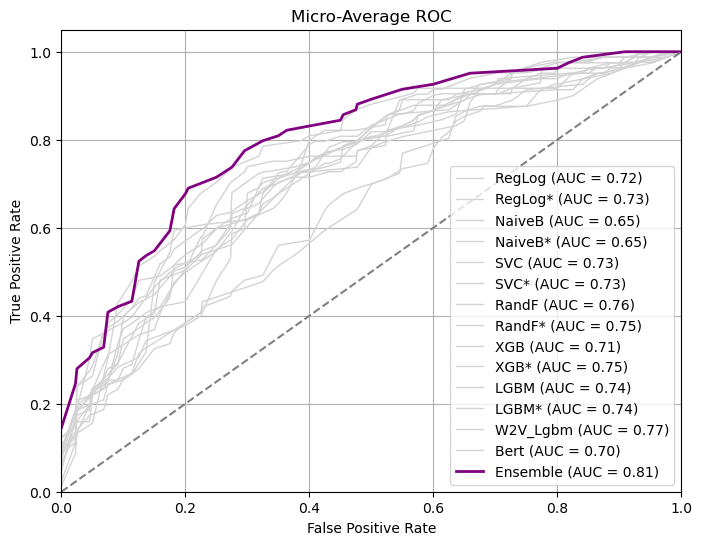

In [136]:
plt.figure(figsize=(8, 6))

for i, y_pred_probabilities in enumerate(probas):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(class_labels) 
    for j in range(n_classes):
        y_true_class = (y_true_encoded == j).astype(int)
        fpr[j], tpr[j], _ = roc_curve(y_true_class, y_pred_probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])

    mean_tpr /= n_classes
    roc_auc_micro = auc(all_fpr, mean_tpr)

    if i == len(probas) - 1:
        plt.plot(all_fpr, mean_tpr, lw=2, label=f'{model_names[i]} (AUC = {roc_auc_micro:.2f})', color='purple')
    else:
        plt.plot(all_fpr, mean_tpr, lw=1, label=f'{model_names[i]} (AUC = {roc_auc_micro:.2f})', color='lightgray')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Power Words

In [129]:
prob_ensemble['CompraIndex'] = 0

for index, noticia in enumerate(prob_ensemble['X_test']):
    tokens = noticia.split()
    
    for palabra in tokens:
        palabra = palabra.strip(".,!?()").lower()
        if palabra in powerWords:
            prob_ensemble.loc[index, 'CompraIndex'] += 0.1

In [130]:
prob_ensemble.head()

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.663392,0.336608,Compra,0.4
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.624243,0.375757,Compra,0.0
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.327072,0.672928,Neutro,0.1
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.506240,0.493760,Compra,0.0
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.539540,0.460460,Compra,0.0
...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.394657,0.605343,Neutro,0.6
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.797477,0.202523,Compra,0.2
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.635084,0.364916,Compra,0.5
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.241577,0.758423,Neutro,0.0


### Funcion Power Index

Por cada palabra que aparezca en el texto de la noticia, sumamos 0.1 para el "Power Index"

In [131]:
# Si CompraIndex > 0.2 entonces cambiar el label a Compra
def CheckPowerWord(row):
    if row['PowerIndex'] >= 0.6 and row['Ensemble Label'] == 'Neutro':
        return 'Compra'
    else:
        return row['Ensemble Label']

prob_ensemble["PowerLabel"] = prob_ensemble.apply(CheckPowerWord, axis=1)

In [132]:
prob_ensemble.head()

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex,PowerLabel
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.663392,0.336608,Compra,0.4,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.624243,0.375757,Compra,0.0,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.327072,0.672928,Neutro,0.1,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.506240,0.493760,Compra,0.0,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.539540,0.460460,Compra,0.0,Compra
...,...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.394657,0.605343,Neutro,0.6,Compra
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.797477,0.202523,Compra,0.2,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.635084,0.364916,Compra,0.5,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.241577,0.758423,Neutro,0.0,Neutro


### Evaluación

In [133]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["Ensemble Label"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["Ensemble Label"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["Ensemble Label"].to_list()))

Accuracy: 72.62%

F1 Score: 72.32

Confusion Matrix:
 [[36  8]
 [15 25]]


In [134]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["PowerLabel"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["PowerLabel"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["PowerLabel"].to_list()))

Accuracy: 76.19%

F1 Score: 75.70

Confusion Matrix:
 [[39  5]
 [15 25]]


In [135]:
prob_ensemble.to_excel('ypf_predicciones_ensemble_power.xlsx', index=False)